# Import

In [3]:
import pandas as pd
import re
import string
import csv
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Reshape, Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Loading Dataset

In [4]:
# Load data
app_reviews_df = pd.read_csv('dataset.csv')
app_reviews_df.head()

,userName,content,score,thumbsUpCount,at,replyContent
0,Pengguna Google,aplikasi lag atau error saat sedang future tra...,3,2,2025-04-08 07:26:05,"Hai Sobat Cuan, mohon maaf atas kendala yang k..."
1,Pengguna Google,UI nya mudah di pahami bagi pemula seperti say...,2,58,2025-02-12 17:52:51,"Hai Sobat Cuan, kami bekerjasama dgn beberapa ..."
2,Pengguna Google,Sejauh ini cukup bagus dari segi tampilan semu...,5,197,2025-03-14 14:22:52,"Hai Sobat Cuan, saat ini Pluang terus berupaya..."
3,Pengguna Google,"Salam Sukses untuk semua, sejauh ini cukup bai...",5,26,2025-03-30 00:42:43,"Hai Sobat Cuan, terima kasih atas apresiasi ya..."
4,Pengguna Google,menurut saya apk sangat membantu bagi pemula s...,5,18,2025-03-29 01:42:01,"Hai Sobat Cuan, terima kasih atas kepercayaan ..."


In [5]:
# Cek info dataset
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27329 entries, 0 to 27328
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userName       27329 non-null  object
 1   content        27329 non-null  object
 2   score          27329 non-null  int64 
 3   thumbsUpCount  27329 non-null  int64 
 4   at             27329 non-null  object
 5   replyContent   26928 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.3+ MB


In [6]:
# Hapus data kosong dan duplikat
clean_df = app_reviews_df.dropna()
clean_df = clean_df.drop_duplicates()
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26928 entries, 0 to 27328
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   userName       26928 non-null  object
 1   content        26928 non-null  object
 2   score          26928 non-null  int64 
 3   thumbsUpCount  26928 non-null  int64 
 4   at             26928 non-null  object
 5   replyContent   26928 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


# Preprocessing

In [7]:
# 1. Cleaning
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)


    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

# 2. Case Folding
def scaffoldingText(text):
    text = text.lower()
    return text

# 3. Tokenizing
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# 4. Filtering (hapus stopwords)
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# 5. Stemming
def stemmingText(words):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

# 6. To Sentence
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [8]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [9]:
clean_df

,userName,content,score,thumbsUpCount,at,replyContent
0,Pengguna Google,aplikasi lag atau error saat sedang future tra...,3,2,2025-04-08 07:26:05,"Hai Sobat Cuan, mohon maaf atas kendala yang k..."
1,Pengguna Google,UI nya mudah di pahami bagi pemula seperti say...,2,58,2025-02-12 17:52:51,"Hai Sobat Cuan, kami bekerjasama dgn beberapa ..."
2,Pengguna Google,Sejauh ini cukup bagus dari segi tampilan semu...,5,197,2025-03-14 14:22:52,"Hai Sobat Cuan, saat ini Pluang terus berupaya..."
3,Pengguna Google,"Salam Sukses untuk semua, sejauh ini cukup bai...",5,26,2025-03-30 00:42:43,"Hai Sobat Cuan, terima kasih atas apresiasi ya..."
4,Pengguna Google,menurut saya apk sangat membantu bagi pemula s...,5,18,2025-03-29 01:42:01,"Hai Sobat Cuan, terima kasih atas kepercayaan ..."
...,...,...,...,...,...,...
27324,Qwerty Manis,Top..,5,0,2022-08-23 23:53:45,"Hai, Qwerty Manis. Terima kasih atas komentar ..."
27325,Rahmat Ragil,mantap....,5,0,2021-04-24 01:59:42,"Hai Rahmat Ragil, Terima kasih telah menggunak..."
27326,Dian Dian,🖒,1,0,2020-11-30 08:23:25,"Hai Dian Dian, Mohon maaf atas ketidaknyamanan..."
27327,Bagus Setiawan,😔😔😔,1,0,2021-08-10 11:35:55,"Hai Bagus Setiawan, Mohon maaf atas ketidaknya..."


In [10]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(scaffoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [11]:
clean_df

,userName,content,score,thumbsUpCount,at,replyContent,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Pengguna Google,aplikasi lag atau error saat sedang future tra...,3,2,2025-04-08 07:26:05,"Hai Sobat Cuan, mohon maaf atas kendala yang k...",aplikasi lag atau error saat sedang future tra...,aplikasi lag atau error saat sedang future tra...,aplikasi lag atau error saat sedang future tra...,"[aplikasi, lag, atau, error, saat, sedang, fut...","[aplikasi, lag, error, future, tradingjadi, ma...",aplikasi lag error future tradingjadi masuk lo...
1,Pengguna Google,UI nya mudah di pahami bagi pemula seperti say...,2,58,2025-02-12 17:52:51,"Hai Sobat Cuan, kami bekerjasama dgn beberapa ...",UI nya mudah di pahami bagi pemula seperti say...,ui nya mudah di pahami bagi pemula seperti say...,ui nya mudah di pahami bagi pemula seperti say...,"[ui, nya, mudah, di, pahami, bagi, pemula, sep...","[ui, mudah, pahami, pemula, sayatapi, tolong, ...",ui mudah pahami pemula sayatapi tolong perbaik...
2,Pengguna Google,Sejauh ini cukup bagus dari segi tampilan semu...,5,197,2025-03-14 14:22:52,"Hai Sobat Cuan, saat ini Pluang terus berupaya...",Sejauh ini cukup bagus dari segi tampilan semu...,sejauh ini cukup bagus dari segi tampilan semu...,sejauh ini cukup bagus dari segi tampilan semu...,"[sejauh, ini, cukup, bagus, dari, segi, tampil...","[bagus, segi, tampilan, oke, khusus, pemula, g...",bagus segi tampilan oke khusus pemula garis ba...
3,Pengguna Google,"Salam Sukses untuk semua, sejauh ini cukup bai...",5,26,2025-03-30 00:42:43,"Hai Sobat Cuan, terima kasih atas apresiasi ya...",Salam Sukses untuk semua sejauh ini cukup baik...,salam sukses untuk semua sejauh ini cukup baik...,salam sukses untuk semua sejauh ini cukup baik...,"[salam, sukses, untuk, semua, sejauh, ini, cuk...","[salam, sukses, baiktop, membeli, menjual, men...",salam sukses baiktop membeli menjual menarik s...
4,Pengguna Google,menurut saya apk sangat membantu bagi pemula s...,5,18,2025-03-29 01:42:01,"Hai Sobat Cuan, terima kasih atas kepercayaan ...",menurut saya apk sangat membantu bagi pemula s...,menurut saya apk sangat membantu bagi pemula s...,menurut saya apk sangat membantu bagi pemula s...,"[menurut, saya, apk, sangat, membantu, bagi, p...","[apk, membantu, pemula, persentase, membeli, m...",apk membantu pemula persentase membeli mudah t...
...,...,...,...,...,...,...,...,...,...,...,...,...
27324,Qwerty Manis,Top..,5,0,2022-08-23 23:53:45,"Hai, Qwerty Manis. Terima kasih atas komentar ...",Top,top,top,[top],[top],top
27325,Rahmat Ragil,mantap....,5,0,2021-04-24 01:59:42,"Hai Rahmat Ragil, Terima kasih telah menggunak...",mantap,mantap,mantap,[mantap],[mantap],mantap
27326,Dian Dian,🖒,1,0,2020-11-30 08:23:25,"Hai Dian Dian, Mohon maaf atas ketidaknyamanan...",,,,[],[],
27327,Bagus Setiawan,😔😔😔,1,0,2021-08-10 11:35:55,"Hai Bagus Setiawan, Mohon maaf atas ketidaknya...",,,,[],[],


# Pelabelan

In [12]:
def load_lexicon_dict(url):
    lexicon = {}
    response = requests.get(url)
    if response.ok:
        reader = csv.reader(StringIO(response.text))
        lexicon = {row[0]: int(row[1]) for row in reader}
    else:
        print(f"Gagal fetch data dari: {url}")
    return lexicon

# Panggil untuk masing-masing
lexicon_positive = load_lexicon_dict('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
lexicon_negative = load_lexicon_dict('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

In [13]:
def sentiment_analysis_lexicon(text, lexicon_pos_dict, lexicon_neg_dict):
    score = 0
    for word in text:
        if word in lexicon_pos_dict:
            score += lexicon_pos_dict[word]
        if word in lexicon_neg_dict:
            score += lexicon_neg_dict[word]

    # Menentukan polaritas berdasarkan score
    if score > 0:
        polarity = 'positif'
    elif score < 0:
        polarity = 'negatif'
    else:
        polarity = 'netral'

    return score, polarity

In [14]:
clean_df[['lexicon_score', 'lexicon_sentiment']] = clean_df['text_akhir'].apply(
    lambda x: pd.Series(sentiment_analysis_lexicon(x.split(), lexicon_positive, lexicon_negative))
)
print(clean_df['lexicon_sentiment'].value_counts())

lexicon_sentiment
positif    13393
negatif     7503
netral      6032
Name: count, dtype: int64


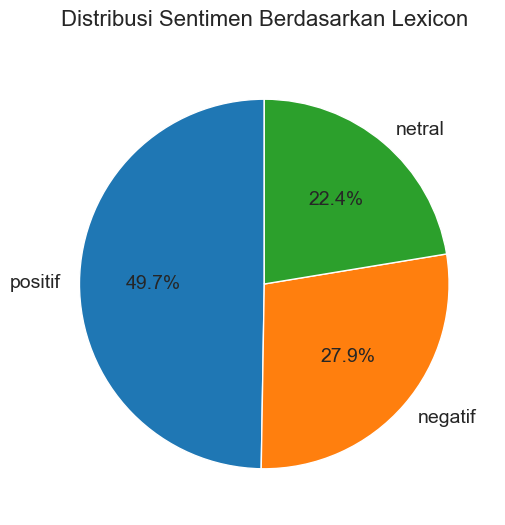

In [15]:
# Hitung jumlah tiap label
sentiment_counts = clean_df['lexicon_sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

# Bikin pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=90)
ax.set_title('Distribusi Sentimen Berdasarkan Lexicon', fontsize=16, pad=20)
plt.show()

In [16]:
# Ambil semua review yang diklasifikasi sebagai 'positif'
positive_reviews = clean_df[clean_df['lexicon_sentiment'] == 'positif']
positive_reviews = positive_reviews[['text_akhir', 'lexicon_score', 'lexicon_sentiment']]
positive_reviews = positive_reviews.sort_values(by='lexicon_score', ascending=False)
positive_reviews = positive_reviews.reset_index(drop=True)
positive_reviews.index += 1

print("Review Paling Positif:")
display(positive_reviews.head(5))

Review Paling Positif:


,text_akhir,lexicon_score,lexicon_sentiment
1,membantu berinvestasi jual beli emas bentuk di...,41,positif
2,aplikasi oke berinvestasi mudah dipahami pemul...,39,positif
3,suka banget pilihan investasinya sp sayang min...,38,positif
4,good good good good good good good,35,positif
5,mantap terimakasih sdh menyediakan aplikasi be...,34,positif


In [17]:
# Ambil semua review yang diklasifikasi sebagai 'negatif'
negative_reviews = clean_df[clean_df['lexicon_sentiment'] == 'negatif']
negative_reviews = negative_reviews[['text_akhir', 'lexicon_score', 'lexicon_sentiment']]
negative_reviews = negative_reviews.sort_values(by='lexicon_score')
negative_reviews = negative_reviews.reset_index(drop=True)
negative_reviews.index += 1

print("Review Paling Negatif:")
display(negative_reviews.head(5))

Review Paling Negatif:


,text_akhir,lexicon_score,lexicon_sentiment
1,kesalahan aplikasi persulit verifikasi susah u...,-40,negatif
2,kakau kasi rating kasi deh aplikasi berse baca...,-39,negatif
3,aplikasi bagus tolong minimal invest kasihan m...,-36,negatif
4,biaya tarik rekening kena pajak biaya trading ...,-35,negatif
5,aplikasinya aplikasi suruh verifikasi identita...,-35,negatif


In [18]:
# Ambil semua review yang diklasifikasi sebagai 'netral'
neutral_reviews = clean_df[clean_df['lexicon_sentiment'] == 'netral']
neutral_reviews = neutral_reviews[['text_akhir', 'lexicon_score', 'lexicon_sentiment']]
neutral_reviews = neutral_reviews.sort_values(by='lexicon_score', ascending=False)
neutral_reviews = neutral_reviews.reset_index(drop=True)
neutral_reviews.index += 1

print("Review Netral (contoh acak):")
display(neutral_reviews.sample(5))

Review Netral (contoh acak):


,text_akhir,lexicon_score,lexicon_sentiment
4786,keren,0,netral
2869,ngertiii,0,netral
3064,bagussss,0,netral
491,newbie main aman,0,netral
4123,request crypto koin request,0,netral


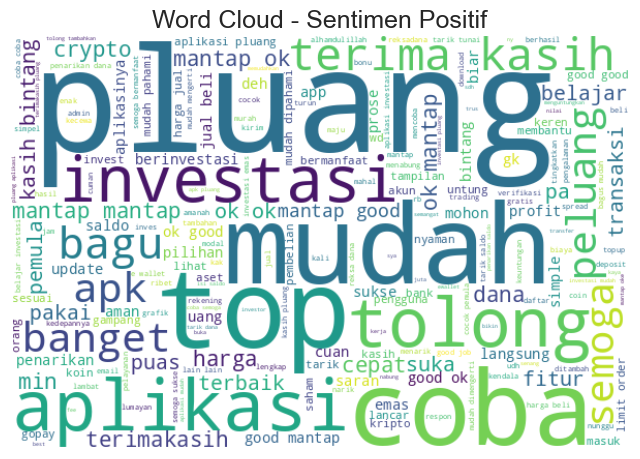

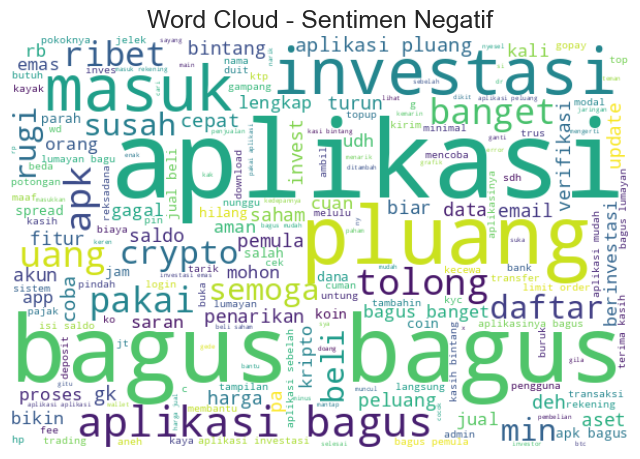

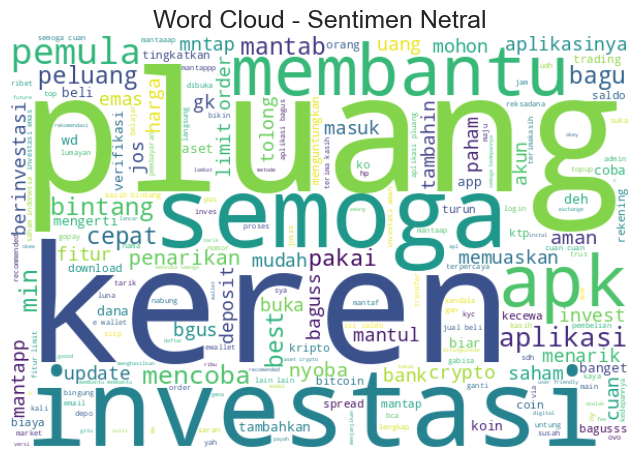

In [19]:
# Fungsi bantu untuk bikin wordcloud per label
def generate_wordcloud(label, df, text_col):
    words = ' '.join([' '.join(row) for row in df[df['lexicon_sentiment'] == label][text_col]])

    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(words)

    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - Sentimen {label.capitalize()}', fontsize=18)
    plt.show()

# Buat wordcloud untuk tiap kategori sentimen
generate_wordcloud('positif', clean_df, 'text_stopword')
generate_wordcloud('negatif', clean_df, 'text_stopword')
generate_wordcloud('netral', clean_df, 'text_stopword')

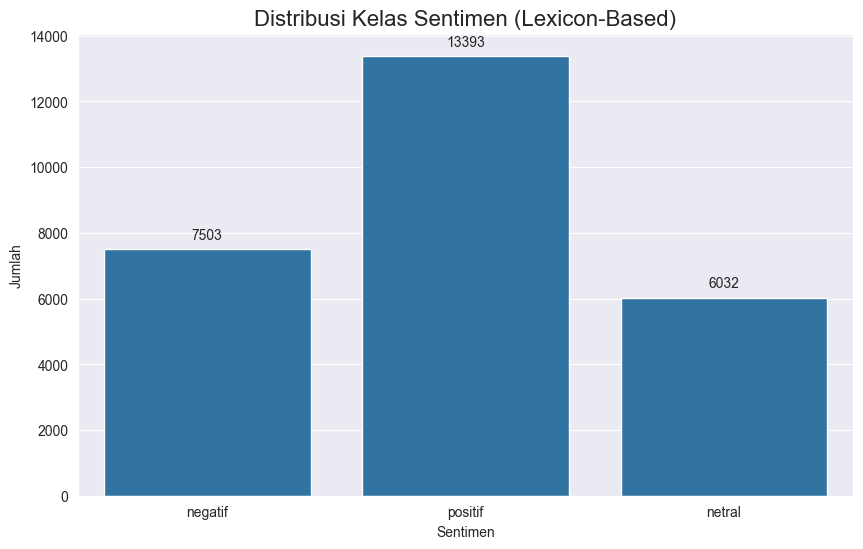

In [20]:
# Set ukuran gambar
plt.figure(figsize=(10, 6))

# Buat countplot untuk distribusi kelas sentimen
class_dist_plot = sns.countplot(x='lexicon_sentiment', data=clean_df)
plt.title('Distribusi Kelas Sentimen (Lexicon-Based)', fontsize=16)

# Tambahkan label jumlah di atas bar
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

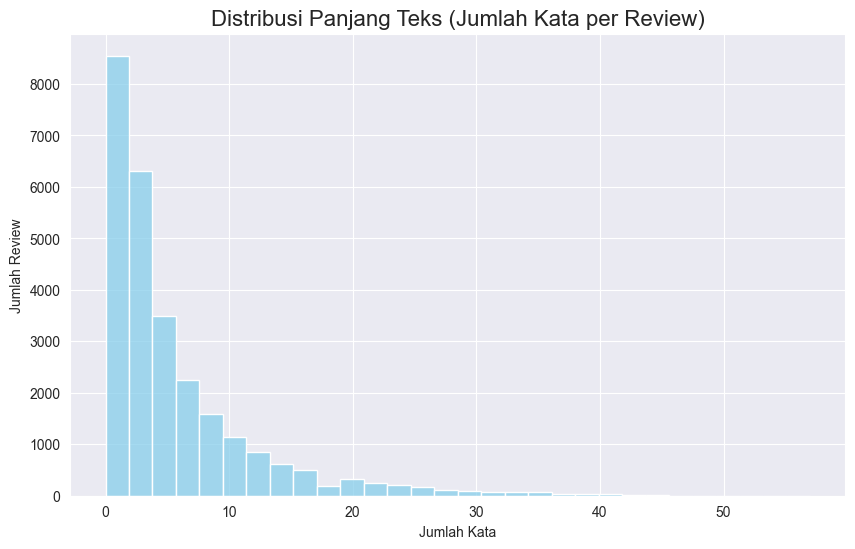

In [21]:
# Tambahkan kolom panjang teks (jumlah kata)
clean_df['text_length'] = clean_df['text_akhir'].apply(lambda x: len(x.split()))

# Visualisasi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(clean_df['text_length'], bins=30, color='skyblue')
plt.title('Distribusi Panjang Teks (Jumlah Kata per Review)', fontsize=16)
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()

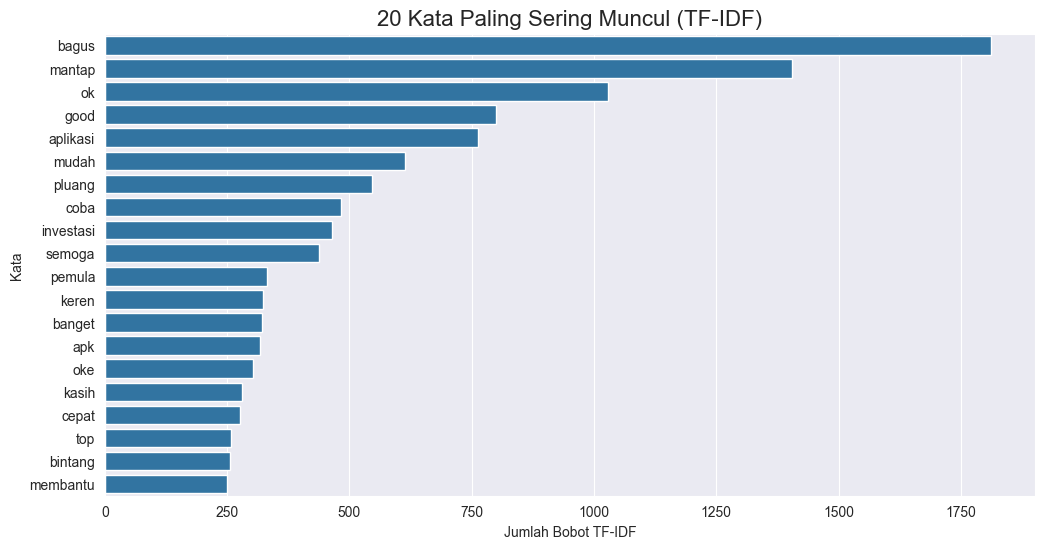

In [22]:
# TF-IDF Vectorizer untuk review yang sudah dibersihkan
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(clean_df['text_akhir'])

# Buat DataFrame dari hasil TF-IDF
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Jumlahkan bobot TF-IDF dari semua review untuk tiap kata
tfidf_sum = tfidf_df.sum().reset_index(name='jumlah')
tfidf_sum = tfidf_sum.rename(columns={'index': 'kata'})
tfidf_top20 = tfidf_sum.sort_values(by='jumlah', ascending=False).head(20)

# Visualisasi bar chart kata paling penting
plt.figure(figsize=(12, 6))
sns.barplot(x='jumlah', y='kata', data=tfidf_top20)
plt.title('20 Kata Paling Sering Muncul (TF-IDF)', fontsize=16)
plt.xlabel('Jumlah Bobot TF-IDF')
plt.ylabel('Kata')
plt.show()

# Data Splitting

In [23]:
# Fitur & Label
X = clean_df['text_akhir']
y = clean_df['lexicon_sentiment']

In [24]:
# Split Data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [25]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=200, min_df=10, max_df=0.8)
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)

# Pemodelan

## Naive Bayes

In [26]:
# Inisialisasi model Naive Bayes (BernoulliNB)
naive_bayes = BernoulliNB()

# Fit model ke data training
naive_bayes.fit(X_train.toarray(), y_train)

# Prediksi
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi
accuracy_train_nb = accuracy_score(y_train, y_pred_train_nb)
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)

print("Naive Bayes - Akurasi Training :", accuracy_train_nb)
print("Naive Bayes - Akurasi Testing  :", accuracy_test_nb)

Naive Bayes - Akurasi Training : 0.8111595952093584
Naive Bayes - Akurasi Testing  : 0.8083921277385815


## Random Forest

In [27]:
# Inisialisasi model Random Forest
random_forest = RandomForestClassifier(random_state=42)

# Fit model ke data training
random_forest.fit(X_train.toarray(), y_train)

# Prediksi
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Evaluasi akurasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

print("Random Forest - Akurasi Training :", accuracy_train_rf)
print("Random Forest - Akurasi Testing  :", accuracy_test_rf)

Random Forest - Akurasi Training : 0.9398384551109461
Random Forest - Akurasi Testing  : 0.8308577794281471


## Logistic Regression

In [28]:
# Inisialisasi model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit model ke data training
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi
accuracy_train_lr = accuracy_score(y_train, y_pred_train_lr)
accuracy_test_lr = accuracy_score(y_test, y_pred_test_lr)

print("Logistic Regression - Akurasi Training :", accuracy_train_lr)
print("Logistic Regression - Akurasi Testing  :", accuracy_test_lr)

Logistic Regression - Akurasi Training : 0.8586482220778016
Logistic Regression - Akurasi Testing  : 0.8510954326030449


## Decision Tree

In [29]:
# Inisialisasi model Decision Tree
decision_tree = DecisionTreeClassifier(random_state=42)

# Training model
decision_tree.fit(X_train.toarray(), y_train)

# Prediksi
y_pred_train_dt = decision_tree.predict(X_train.toarray())
y_pred_test_dt = decision_tree.predict(X_test.toarray())

# Evaluasi akurasi
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
accuracy_test_dt = accuracy_score(y_test, y_pred_test_dt)

print("Decision Tree - Akurasi Training :", accuracy_train_dt)
print("Decision Tree - Akurasi Testing  :", accuracy_test_dt)

Decision Tree - Akurasi Training : 0.9398384551109461
Decision Tree - Akurasi Testing  : 0.7983661344225771


# Pemodelan Menggunakan Deep Learning

In [30]:
# Ambil teks dan label
X = clean_df['text_akhir'].values
y = clean_df['lexicon_sentiment'].values  # atau label terbaik lo

# Tokenizer
MAX_VOCAB = 10000
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

# Padding
MAX_LENGTH = 150
X_padded = pad_sequences(X_sequences, maxlen=MAX_LENGTH, padding="post", truncating="post")

In [31]:
# Encode Label
unique_labels = list(set(y))
label_encoder = tf.keras.layers.StringLookup(vocabulary=unique_labels, mask_token=None)
y_encoded = label_encoder(y).numpy()

# Cek label
print("Label Mapping:", dict(zip(label_encoder.get_vocabulary(), range(len(label_encoder.get_vocabulary())))))

Label Mapping: {'[UNK]': 0, np.str_('netral'): 1, np.str_('positif'): 2, np.str_('negatif'): 3}


In [32]:
# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_encoded, test_size=0.3, random_state=42
)

In [33]:
# Generate Skip-Gram Pairs
skip_grams = []
window_size = 4

for text in X_train:
    for i, target in enumerate(text):
        if target == 0:
            continue
        for j in range(max(i - window_size, 0), min(i + window_size + 1, len(text))):
            context = text[j]
            if i != j and context != 0:
                skip_grams.append([target, context])

target_words = np.array([pair[0] for pair in skip_grams])
context_words = np.array([pair[1] for pair in skip_grams])

In [34]:
# Train Skip-Gram Embedding Model
embedding_dim = 300
vocabulary_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

model_skipgram = Sequential([
    Embedding(input_dim=vocabulary_size, output_dim=embedding_dim),
    Reshape((embedding_dim,)),
    Dense(vocabulary_size, activation='softmax'),
])

model_skipgram.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model_skipgram.fit(target_words, context_words, epochs=5, batch_size=1024)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 77s 142ms/step - loss: 8.0033
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 73s 136ms/step - loss: 6.6830
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 77s 143ms/step - loss: 6.5094
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 74s 137ms/step - loss: 6.3667
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 72s 134ms/step - loss: 6.2130


In [35]:
# Ambil Embedding Matrix
embedding_matrix = model_skipgram.layers[0].get_weights()[0]

In [36]:
# Bangun BiLSTM Model Final
model_bilstm = Sequential([
    Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True
    ),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(len(label_encoder.get_vocabulary()), activation="softmax")
])

# Compile model
model_bilstm.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

# Early Stopping biar gak overfit
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

In [37]:
# Train Model BiLSTM
history = model_bilstm.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 68s 207ms/step - accuracy: 0.6384 - loss: 0.8074 - val_accuracy: 0.8591 - val_loss: 0.3950
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 61s 208ms/step - accuracy: 0.8776 - loss: 0.3453 - val_accuracy: 0.9090 - val_loss: 0.2592
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.9196 - loss: 0.2444 - val_accuracy: 0.9235 - val_loss: 0.2216
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 62s 212ms/step - accuracy: 0.9364 - loss: 0.1853 - val_accuracy: 0.9318 - val_loss: 0.2038
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - accuracy: 0.9509 - loss: 0.1459 - val_accuracy: 0.9340 - val_loss: 0.2011
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.9577 - loss: 0.1238 - val_accuracy: 0.9233 - val_loss: 0.2762
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 61s 206ms/step - accuracy: 0.9650 - loss: 0.1055 - val_accuracy: 0.9366 - val_loss: 0.2298
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.9715 - loss: 0

# Evaluasi

In [38]:
# Membuat DataFrame hasil evaluasi akurasi
results_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree'],
    'Accuracy Train': [accuracy_train_nb, accuracy_train_rf, accuracy_train_lr, accuracy_train_dt],
    'Accuracy Test': [accuracy_test_nb, accuracy_test_rf, accuracy_test_lr, accuracy_test_dt]
})

# Menampilkan semua akurasi
print("Akurasi Train & Test Semua Model:")
display(results_df)

# Menampilkan hanya Accuracy Test, diurutkan
accuracy_test_sorted = results_df[['Model', 'Accuracy Test']].sort_values(by='Accuracy Test', ascending=False)

print("\nModel dengan Akurasi Testing Tertinggi:")
display(accuracy_test_sorted)

Akurasi Train & Test Semua Model:


,Model,Accuracy Train,Accuracy Test
0,Naive Bayes,0.811160,0.808392
1,Random Forest,0.939838,0.830858
2,Logistic Regression,0.858648,0.851095
3,Decision Tree,0.939838,0.798366



Model dengan Akurasi Testing Tertinggi:


,Model,Accuracy Test
2,Logistic Regression,0.851095
1,Random Forest,0.830858
0,Naive Bayes,0.808392
3,Decision Tree,0.798366


In [ ]:
# Evaluasi Model Deep Learning
train_acc_dl = model_bilstm.evaluate(X_train, y_train, verbose=0)[1]
test_acc_dl = model_bilstm.evaluate(X_test, y_test, verbose=0)[1]

print(f"\nBiLSTM + Skip-gram = Train Acc: {train_acc_dl:.4f}, Test Acc: {test_acc_dl:.4f}")

# Inference (Prediksi Kalimat Baru)

In [118]:
# Input kalimat dari user
kalimat_baru = input("Masukkan kalimat baru: ")

# Preprocessing
cleaned = cleaningText(kalimat_baru)
scaffolding = scaffoldingText(cleaned)
tokenized = tokenizingText(scaffolding)
filtered = filteringText(tokenized)
stemmed = stemmingText(filtered)
final_sentence = toSentence(stemmed)

# Logistic Regression
X_kalimat_lr = tfidf.transform([final_sentence])
prediksi_lr = logistic_regression.predict(X_kalimat_lr)[0]

# Deep Learning BiLSTM
sequence = tokenizer.texts_to_sequences([final_sentence])
padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post')
prediksi_dl_index = model_bilstm.predict(padded).argmax(axis=1)[0]
prediksi_dl = label_encoder.get_vocabulary()[prediksi_dl_index]

print(f"\nKalimat: {kalimat_baru}")
print(f"Setelah Preprocessing: {final_sentence}")
print("Hasil Prediksi:")
print(f"  Logistic Regression : {prediksi_lr.upper()}")
print(f"  BiLSTM (Deep Learning): {prediksi_dl.upper()}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

Kalimat: biasa aja
Setelah Preprocessing: aja
Hasil Prediksi:
  Logistic Regression : NETRAL
  BiLSTM (Deep Learning): NETRAL
